# Imports

In [1]:
%load_ext autoreload
%autoreload 2

#import viewdat_cno_lib as vdl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
import geopy.distance
import datetime
import time
import os
import subprocess
import math
import glob
import shutil

# Functions

In [2]:
def combine_T04(hourly_dir, out_name):
    if os.path.isfile(out_name):
        print(f'{out_name} already exists.. deleting it')
        os.remove(out_name)

    #print(f"   combine({fname_base}, {out_name})")
    # List of files to concat
    flist = sorted(glob.glob('*T04', root_dir=os.path.join(hourly_dir)))

    with open(out_name, 'wb') as wfd:
        for f in flist:
            f_path = os.path.join(hourly_dir, f)
            print(f"    appending {f} to {out_name}")
            with open(f_path, 'rb') as fd:
                shutil.copyfileobj(fd, wfd)

def pos_read(fname_tsv, header_n_rows=159):
    if not os.path.isfile(fname_tsv):
        print(f"Unable to find {fname_tsv}")
        return None
    # Import the data into a Pandas DataFrame, and do some cleanup
    df = pd.read_csv(fname_tsv, delimiter='\t', header=header_n_rows, na_values=['Nan'])
    df.rename(columns=lambda x: x.strip(), inplace=True)  # drop whitespace
    df = df.replace({'Nan': np.nan})
    #print(list(df.columns))
    cols_rename = {
        '%Week': 'Week',
        # 'TRACK': 'Track',
    }
    df.rename(columns=cols_rename, inplace=True)
    #df = week_rollover_unwrap(df)
    return df

In [3]:
# This class was brazenly stolen from mutils.py in the Sunnyvale CVS repo
class OrbitConst(object):
    """
    Orbital constants
    """
    PI = 3.14159265358979323846
    A_WGS84 = 6378137.0
    B_WGS84 = 6356752.314245179
    E2_WGS84 = 6.69437999013e-3
    ONE_MIN_E2 = 0.99330562000987
    SQRT_ONE_MIN_E2 = 9.96647189335258e-1
    

# This function was brazenly stolen from mutils.py in the Sunnyvale CVS repo
def llh2enu(llh, ref_llh, is_rad=False, is_ref_rad=False):
    """
    Convert lat/lon/height to delta east/north/up.
    llh = array of lat/lon/height [lat/lon in degrees by default]
    ref_llh = point or array of lat/lon/height [lat/lon in degrees by default]
    is_rad = True -> "llh" lat/lon is radians, else in degrees
    is_ref_rad = True -> "ref_llh" lat/lon is radians, else in degrees
    """
    # Make sure inputs are arrays
    if len(np.shape(llh)) == 1:
        llh = llh.reshape((1, len(llh)))
    if len(np.shape(ref_llh)) == 1:
        ref_llh = ref_llh.reshape((1, len(ref_llh)))

    # Convert to radians?
    scale1 = np.ones(np.shape(llh))
    scale2 = np.ones(np.shape(ref_llh))
    ref_lat = np.copy(ref_llh[:, 0])
    if not is_rad:
        scale1[:, 0:2] *= OrbitConst.PI/180
    if not is_ref_rad:
        scale2[:, 0:2] *= OrbitConst.PI/180
        ref_lat *= OrbitConst.PI/180

    # Compute the residuals
    dllh = llh*scale1 - ref_llh*scale2

    # Compute Radii of Curvature
    W = np.sqrt(1 - OrbitConst.E2_WGS84 * np.sin(ref_lat)**2)
    N = OrbitConst.A_WGS84 / W
    M = OrbitConst.A_WGS84 * (1 - OrbitConst.E2_WGS84) / W**3

    # Compute Metric Components
    dE = dllh[:, 1] * N * np.cos(ref_lat)
    dN = dllh[:, 0] * M
    dU = dllh[:, 2]

    return (dE, dN, dU)

In [4]:
def calc_heading(lat1, long1, lat2, long2):
    rlat1 = math.radians(lat1)
    rlat2 = math.radians(lat2)
    rlon1 = math.radians(long1)
    rlon2 = math.radians(long2)
    dLon = rlon2 - rlon1
    x = math.cos(rlat2) * math.sin(dLon)
    y = math.cos(rlat1) * math.sin(rlat2)
    y -= math.sin(rlat1) * math.cos(rlat2) * math.cos(dLon)
    heading = np.arctan2(x, y)
    heading = math.degrees(heading)
    heading = (heading + 180.0) % 360.0   # convert from -180:+180 to 0:360
    return heading

In [5]:
from datetime import datetime, timedelta
import pytz

def gps_datetime(time_week, time_ms, leap_seconds=37):
    # 37 leap seconds seems to be correct for 2016-12-31 through at least 2023
    gps_epoch = datetime(1980, 1, 6, tzinfo=pytz.utc)
    # gps_time - utc_time = leap_seconds
    return gps_epoch + timedelta(weeks=time_week, milliseconds=time_ms, seconds=-leap_seconds)

print(gps_datetime(2292, 266792379))
print(gps_datetime(2319, 500177.0*1000))

2023-12-13 02:05:55.379000+00:00
2024-06-21 18:55:40+00:00


In [6]:
def delta_enu_start(df):
    df[['dN', 'dE', 'dH']] = df[['N', 'E', 'Ele']] - df.iloc[0][['N', 'E', 'Ele']]
    return df

In [7]:
def delta_pos_start(df, start_pt=None):
    if start_pt is None:
        start = df.iloc[0]
        start_pt = np.array([start.MLat, start.MLon, start.MHgt])
    #print(f'start_pt: {start_pt}')
    llh = np.array(df[['MLat', 'MLon', 'MHgt']])
    #print('llh:')
    #print(llh)
    a = np.array(llh2enu(llh, start_pt))
    #print('a:')
    #display(a)
    #print(a.shape)
    #print(df.shape)
    df[['dE', 'dN', 'dU']] = a.transpose()
    return df

In [8]:
def dms_to_dd(d:float, m:float, s:float):
    dd = d + float(m)/60 + float(s)/3600
    if d<0:
        dd = float(d) - float(m)/60 - float(s)/3600
    else:
        dd = float(d) + float(m)/60 + float(s)/3600
    return dd

In [9]:
def week_rollover_unwrap(df):
    '''
    Find time greater than one week & remove 604800 seconds
    '''
    SECS_PER_WEEK = 604800
    min_week = df.Week.min()
    weeks2roll = df.Week.max() - min_week
    if weeks2roll > 0:
        if weeks2roll > 1:
            print(f'WARNING: Week Rollevers END - START = {weeks2roll} > 1')
        elif weeks2roll == 1:
            print('Week rollever found in timing')
    df['adj_time'] = SECS_PER_WEEK*(df.Week-min_week) + df.Time
    return df

# Viewdat

In [10]:
def import_t04_dir(dir_name, fname_base):
    fname_T04 = f'{fname_base}.T04'
    fname_tsv = f'{fname_base}_pos.tsv'

    combine_T04(dir_name, fname_T04)
    cmd = f'viewdat -d35:2 --t04_vector_position -mb -h {fname_T04} -o{fname_tsv}'.replace(' ', ',').split(',')
    print(f'{cmd=}')
    subprocess.run(cmd)
    df = pos_read(fname_tsv, 159) #102)
    df = df[['Week', 'Time', 'RefSys', 
             'MFixMode', 'MFixType', 'MFixInfo', 
             'MLat', 'MLon', 'MHgt', 'MSigN', 'MSigE', 'MSigU', 'MSigEN', 'MSigEU', 'MSigNU', 
             'RefLat', 'RefLon', 'RefHgt', 
             'VLat', 'VLon', 'VHgt', 'VSigN', 'VSigE', 'VSigU', 'VSigEN', 'VSigEU', 'VSigNU', 
             'corrAge']]
    df = delta_pos_start(df)
    df = week_rollover_unwrap(df)
    df['time_utc'] = df.apply(lambda x: gps_datetime(time_week = x['Week'], time_ms = x['Time']*1000), axis=1)
    return df

In [11]:
#df_judo = import_t04_dir('Judo_EB93', 'judo')
#display(df_judo)

# Montera POSition (Titan Positions from receivers)

In [12]:
#subprocess.run('pos_in_one --dir .')

In [13]:
def read_pos_montera(dir_name, start_pt=None):
    fname_csv = f'gen_data/position/{dir_name}/pos_ant.csv'
    df = pd.read_csv(fname_csv)
    df.Time = df.Time/1000.0
    #df['time_utc'] = df.apply(lambda x: gps_datetime(time_week = x['Week'], time_ms = x['Time']*1000), axis=1)
  
    #df = df[['Week', 'Time', 'RefSys', 
    #         'MFixMode', 'MFixType', 'MFixInfo', 
    #         'MLat', 'MLon', 'MHgt', 'MSigN', 'MSigE', 'MSigU', 'MSigEN', 'MSigEU', 'MSigNU', 
    #         'RefLat', 'RefLon', 'RefHgt', 
    #         'VLat', 'VLon', 'VHgt', 'VSigN', 'VSigE', 'VSigU', 'VSigEN', 'VSigEU', 'VSigNU', 
    #         'corrAge']]
    df = delta_pos_start(df, start_pt)
    df = week_rollover_unwrap(df)
    return df

In [14]:
df_start = pd.read_csv(f'gen_data/position/BX992/pos_ant.csv')
df_start.Time = df_start.Time/1000.0
start = df_start.iloc[0]
start_pt = np.array([start.MLat, start.MLon, start.MHgt])

df_bx = read_pos_montera('BX992', start_pt)
#display(df_bx)

In [15]:
df_eb93 = read_pos_montera('EB93', start_pt)
#display(df_eb93)
df_eb95 = read_pos_montera('EB95', start_pt)
#display(df_eb95)

## Match Timestamps

In [53]:
# Figure out which DataFrame is the smallest
print(df_bx.shape, df_eb93.shape, df_eb95.shape)

times = np.intersect1d(df_eb93.Time, df_eb95.Time)
print(len(times))
times = np.intersect1d(times, df_bx.Time)
print(len(times))
print(times)
print('')

# Only use the Time stamps from the smallest data set (EB93)
df_bx = df_bx[df_bx.Time.isin(times)]
df_eb93 = df_eb93[df_eb93.Time.isin(times)]
df_eb95 = df_eb95[df_eb95.Time.isin(times)]
print(df_bx.shape, df_eb93.shape, df_eb95.shape)
print(df_bx.Time.min(), df_bx.Time.max())
print(df_eb93.Time.min(), df_eb93.Time.max())
print(df_eb95.Time.min(), df_eb95.Time.max())
print('')

#plt.plot(df_bx.Time, )
#plt.plot(df_eb93.Time)
#plt.plot(df_eb95.Time)
#plt.xlim([0, 100])

dt = np.array(df_eb93.Time)- np.array(df_bx.Time)
for n in [0, 1, 10, 100, 500, 100, 999, 1000, 2560]:
    print(n, df_bx.Time.iloc[n], df_eb93.Time.iloc[n], df_eb95.Time.iloc[n], df_bx.Time.iloc[n] - df_eb93.Time.iloc[n], dt[n])

(2561, 64) (2561, 66) (2561, 66)
2561
2561
[152235. 152236. 152237. ... 154797. 154798. 154799.]

(2561, 64) (2561, 66) (2561, 66)
152235.0 154799.0
152235.0 154799.0
152235.0 154799.0

0 152235.0 152235.0 152235.0 0.0 0.0
1 152236.0 152236.0 152236.0 0.0 0.0
10 152245.0 152245.0 152245.0 0.0 0.0
100 152335.0 152335.0 152335.0 0.0 0.0
500 152735.0 152735.0 152735.0 0.0 0.0
100 152335.0 152335.0 152335.0 0.0 0.0
999 153238.0 153238.0 153238.0 0.0 0.0
1000 153239.0 153239.0 153239.0 0.0 0.0
2560 154799.0 154799.0 154799.0 0.0 0.0


## Dist to BX

In [58]:
# Calculate distances to the BX
df_bx['d_to_bx'] = np.sqrt((np.array(df_bx.dE) - np.array(df_bx.dE))**2 + (np.array(df_bx.dN) - np.array(df_bx.dN))**2)
df_eb93['d_to_bx'] = np.sqrt((np.array(df_eb93.dE) - np.array(df_bx.dE))**2 + (np.array(df_eb93.dN) - np.array(df_bx.dN))**2)
df_eb95['d_to_bx'] = np.sqrt((np.array(df_eb95.dE) - np.array(df_bx.dE))**2 + (np.array(df_eb95.dN) - np.array(df_bx.dN))**2)

In [26]:
print(df_bx.shape)
print(df_eb93.shape)
print(df_eb95.shape)

(2561, 64)
(2561, 66)
(2561, 66)


# Plots

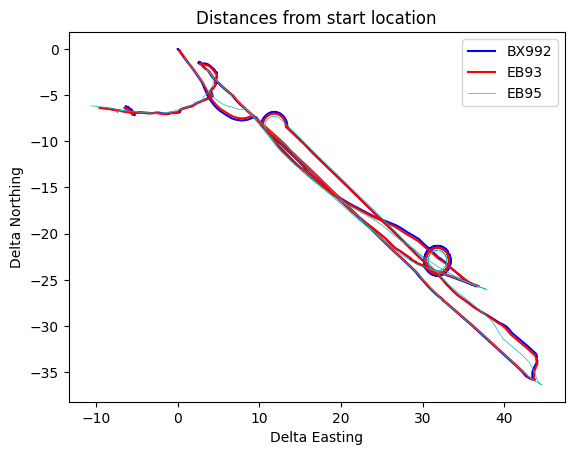

In [19]:
plt.plot(df_bx.dE, df_bx.dN, 'b-')
plt.plot(df_eb93.dE, df_eb93.dN, 'r-')
plt.plot(df_eb95.dE, df_eb95.dN, 'c-', linewidth=0.5)

plt.xlabel('Delta Easting')
plt.ylabel('Delta Northing')
plt.title('Distances from start location')
plt.legend(['BX992', 'EB93', 'EB95'])

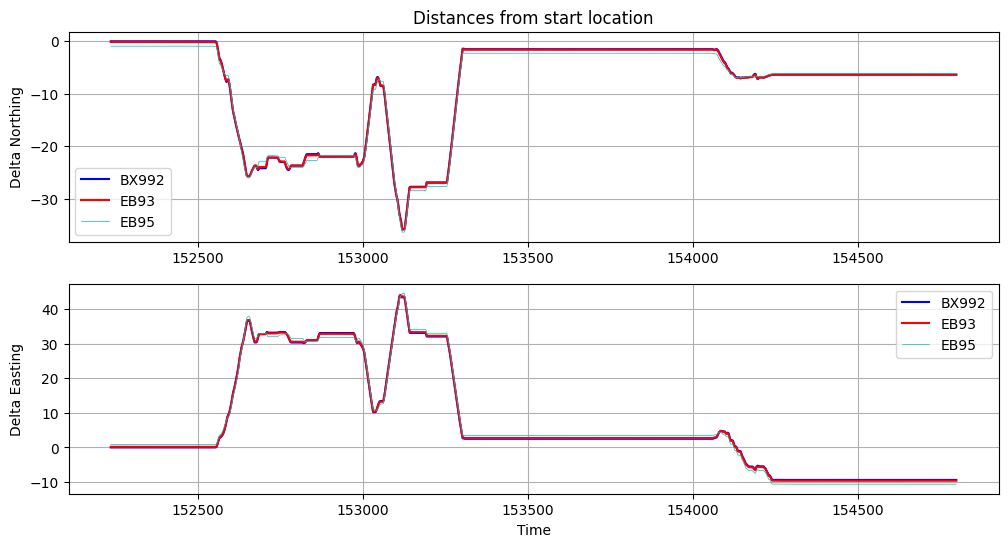

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))

ax[0].plot(df_bx.Time, df_bx.dN, 'b-')
ax[0].plot(df_eb93.Time, df_eb93.dN, 'r-')
ax[0].plot(df_eb95.Time, df_eb95.dN, 'c-', linewidth=0.5)

#ax[0].set_xlabel('Time')
ax[0].set_ylabel('Delta Northing')
ax[0].set_title('Distances from start location')
ax[0].legend(['BX992', 'EB93', 'EB95'])
ax[0].grid(True)

ax[1].plot(df_bx.Time, df_bx.dE, 'b-')
ax[1].plot(df_eb93.Time, df_eb93.dE, 'r-')
ax[1].plot(df_eb95.Time, df_eb95.dE, 'c-', linewidth=0.5)

ax[1].set_xlabel('Time')
ax[1].set_ylabel('Delta Easting')
#ax[1].title('Distances from start location')
ax[1].legend(['BX992', 'EB93', 'EB95'])
ax[1].grid(True)

## Dist to BX

0.23372697090771716 0.21520926036843055 0.2631118256731747 0.0027583353621951356
1.240363953505124 1.2174956497112177 1.2737685511399963 0.0036297449127406104


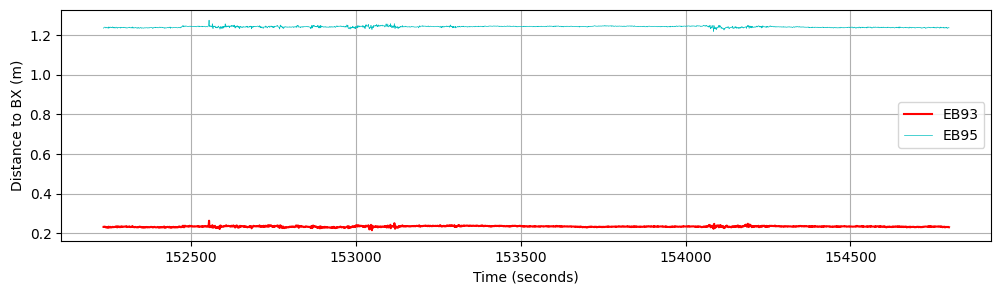

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(12,3))
plt.plot(df_eb93.Time, df_eb93.d_to_bx, 'r-')
plt.plot(df_eb95.Time, df_eb95.d_to_bx, 'c-', linewidth=0.5)
#plt.ylim([0, 5])
plt.xlabel('Time (seconds)')
plt.ylabel('Distance to BX (m)')
#plt.title('Distances from start location')
plt.legend(['EB93', 'EB95'])
plt.grid(True)

print(df_eb93.d_to_bx.mean(), df_eb93.d_to_bx.min(), df_eb93.d_to_bx.max(), df_eb93.d_to_bx.std(), )
print(df_eb95.d_to_bx.mean(), df_eb95.d_to_bx.min(), df_eb95.d_to_bx.max(), df_eb95.d_to_bx.std())

In [ ]:
list(df_bx.columns)

plt.plot(df_eb93.Time, df_eb93.MFixType, 'b-')
plt.plot(df_eb93.Time, df_eb93.MFixType, 'r-')
plt.plot(df_eb95.Time, df_eb95.MFixType, 'c-', linewidth=0.5)

plt.xlabel('Time')
plt.ylabel('Fix Type')
#plt.title('Distances from start location')
plt.legend(['BX992', 'EB93', 'EB95'])

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 6))

ax0.plot(df_72310017.t, df_72310017.dE, 'b-')
ax0.plot(df_72613087.t, df_72613087.dE, 'r-')
ax0.plot(df_r780.time_utc, df_r780.dE, 'c-')
ax0.plot(df_judo.time_utc, df_judo.dE, 'g-')
ax0.set_title('Distances from start location')
ax0.set_ylabel('Delta Easting')

ax1.plot(df_72310017.t, df_72310017.dN, 'b-')
ax1.plot(df_72613087.t, df_72613087.dN, 'r-')
ax1.plot(df_r780.time_utc, df_r780.dN, 'c-')
ax1.plot(df_judo.time_utc, df_judo.dN, 'g-')
ax1.set_ylabel('Delta Northing')

ax2.plot(df_72310017.t, df_72310017.dH, 'b-')
ax2.plot(df_72613087.t, df_72613087.dH, 'r-')
ax2.plot(df_r780.time_utc, df_r780.dU, 'c-')
ax2.plot(df_judo.time_utc, df_judo.dU, 'g-')
ax2.set_ylabel('Delta Up')

plt.xlabel('Time')

plt.legend(['MT 72310017', 'MT 72613087', 'R780', 'Judo Primary'])

# Antenna Distance

# TBC Import

In [78]:
def delta_pos_start_tbc(df):
    start = df.iloc[0]
    start_pt = np.array([start.N, start.E, start.El])
    #print(f'start_pt: {start_pt}')
    llh = np.array(df[['N', 'E', 'El']])
    #print('llh:')
    #print(llh)
    a = np.array(llh2enu(llh, start_pt))
    #print('a:')
    #display(a)
    #print(a.shape)
    #print(df.shape)
    df[['dE', 'dN', 'dU']] = a.transpose()
    return df

In [79]:
df_c3 = pd.read_csv('c3.csv')
df_c9 = pd.read_csv('c9.csv')
df_c11 = pd.read_csv('c11.csv')

In [80]:
df_c3 = delta_pos_start_tbc(df_c3)
df_c9 = delta_pos_start_tbc(df_c9)
df_c11 = delta_pos_start_tbc(df_c11)

Text(0.5, 1.0, 'Distances from start location')

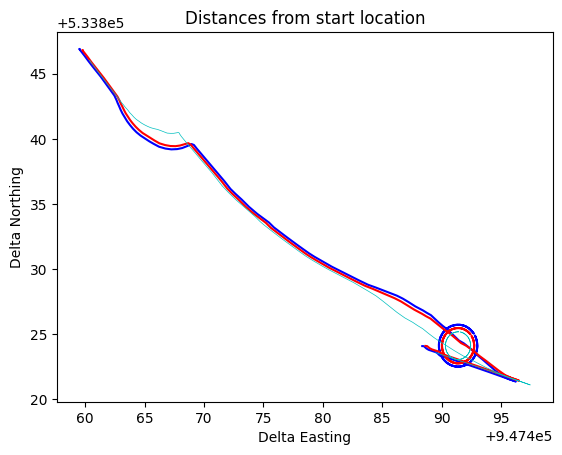

In [81]:
plt.plot(df_c3.E, df_c3.N, 'b-')
plt.plot(df_c9.E, df_c9.N, 'r-')
plt.plot(df_c11.E, df_c11.N, 'c-', linewidth=0.5)

plt.xlabel('Delta Easting')
plt.ylabel('Delta Northing')
plt.title('Distances from start location')
#plt.legend(['BX992', 'EB93', 'EB95'])

## Match Timestamps

In [82]:
# Figure out which DataFrame is the smallest
print(df_c3.shape, df_c9.shape, df_c11.shape)

times = np.intersect1d(df_c9.Time, df_c11.Time)
print(f'{len(times)=}')
times = np.intersect1d(times, df_c3.Time)
print(f'{len(times)=}', times.min(), times.max())
#print(times)
print('')

# Only use the Time stamps from the smallest data set (EB93)
df_c3 = df_c3[df_c3.Time.isin(times)]
df_c9 = df_c9[df_c9.Time.isin(times)]
df_c11 = df_c11[df_c11.Time.isin(times)]
print(df_c3.shape, df_c9.shape, df_c11.shape)
print(df_c3.Time.min(), df_c3.Time.max())
print(df_c9.Time.min(), df_c9.Time.max())
print(df_c11.Time.min(), df_c11.Time.max())
print('')

(817, 8) (809, 8) (765, 8)
len(times)=765
len(times)=765 45502.7617708333 45502.7706134259

(765, 8) (765, 8) (765, 8)
45502.7617708333 45502.7706134259
45502.7617708333 45502.7706134259
45502.7617708333 45502.7706134259



## Distance to BX

In [85]:
# Calculate distances to the BX
df_c9['d_to_bx'] = np.sqrt((np.array(df_c9.E) - np.array(df_c3.E))**2 + (np.array(df_c9.N) - np.array(df_c3.N))**2)
df_c11['d_to_bx'] = np.sqrt((np.array(df_c11.E) - np.array(df_c3.E))**2 + (np.array(df_c11.N) - np.array(df_c3.N))**2)

0.2660122404122731 0.2565638322453846 0.2791594526491304 0.003449577312838043
1.2456937962872745 1.2290927548938158 1.2640166137954425 0.0046315692869618634


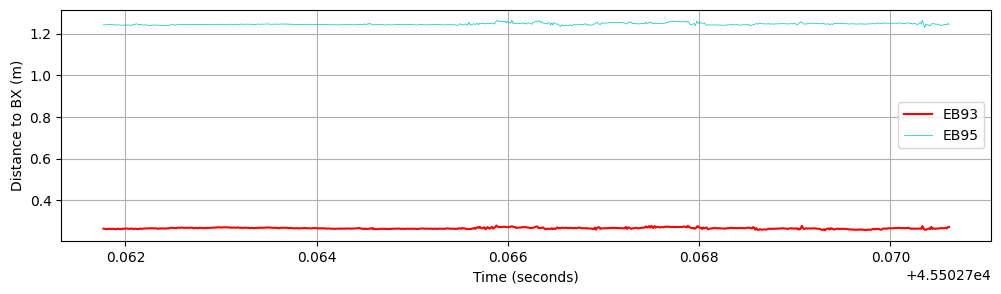

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(12,3))
plt.plot(df_c9.Time, df_c9.d_to_bx, 'r-')
plt.plot(df_c11.Time, df_c11.d_to_bx, 'c-', linewidth=0.5)
#plt.ylim([0, 5])
plt.xlabel('Time (seconds)')
plt.ylabel('Distance to BX (m)')
#plt.title('Distances from start location')
plt.legend(['EB93', 'EB95'])
plt.grid(True)

print(df_c9.d_to_bx.mean(), df_c9.d_to_bx.min(), df_c9.d_to_bx.max(), df_c9.d_to_bx.std(), )
print(df_c11.d_to_bx.mean(), df_c11.d_to_bx.min(), df_c11.d_to_bx.max(), df_c11.d_to_bx.std())